In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk.corpus
from nltk.corpus import stopwords
from datetime import date, datetime
import emoji
import re
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import unidecode
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample
from sklearn.metrics import precision_score, recall_score
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Ridge
from sklearn.compose import ColumnTransformer
import warnings
warnings.filterwarnings('ignore')

### Load Data

In [2]:
df = pd.read_csv("SentimentLabeled_10112022.csv")

In [3]:
df.columns

Index(['date', 'text', 'userid_str', 'status_id_str', 'id', 'name', 'birth',
       'term_partisanship', 'term_type', 'term_state', 'country', 'Bucket',
       'SentimentScore', 'version'],
      dtype='object')

In [4]:
#Select tweets about China only
df = df[df['country']=='China']

In [5]:
df = df[['text', 'id', 'Bucket', 'SentimentScore']]

### Bucket Data Preprocessing

In [6]:
df['Bucket'].value_counts()

1         8812
2 or 3    2053
2          160
1.0        122
3           32
2.0         10
3.0          1
Name: Bucket, dtype: int64

In [7]:
def standardize_bucket(bucket):
    if ((bucket == '1.0') | (bucket == '1')):
        return '1'
    elif ((bucket == '2') | (bucket == '3') | (bucket == '2.0') | (bucket == '3.0')):
        return '2 or 3'
    else:
        return bucket
    
df['Bucket'] = df['Bucket'].apply(standardize_bucket)
df['Bucket'].value_counts(dropna=False)

1         8934
2 or 3    2256
NaN        934
Name: Bucket, dtype: int64

In [8]:
#bucket data cleaning
#Step 1: Remove tweets that are in both buckets
#Step 2: Remove tweets without a bucket (null)
#Step 3: Remove duplicates
df_bucket_count = pd.DataFrame(df.groupby('id')['Bucket'].nunique())
df_bucket_count.reset_index(inplace=True)
df_bucket_count.columns = ['tweet_id', 'bucket_num']
bucket_df = df.merge(df_bucket_count, left_on='id', right_on='tweet_id')
#Remove tweets that are in more than one bucket or has null value for bucket
bucket_df = bucket_df[bucket_df['bucket_num'] == 1]
bucket_df = bucket_df[(bucket_df['Bucket'] == '1') | (bucket_df['Bucket'] == '2 or 3')]
bucket_df = bucket_df.drop_duplicates(subset=['id']).reset_index(drop=True)
bucket_df = bucket_df[['text', 'Bucket']]

In [9]:
bucket_df.head(3)

,text,Bucket
0,I commend all of law enforcement for the secur...,2 or 3
1,"Socialist tyrant Maduro starves, tortures his ...",1
2,"Russia, China, India, Pakistan, North Korea, I...",1


In [10]:
bucket_df['Bucket'].value_counts(dropna=False)

1         8085
2 or 3    2062
Name: Bucket, dtype: int64

### Text Preprocessing

In [11]:
def extract_symbols(df, col):
    # extract @s
    at_users = []
    for row in range(len(df)):
        matches = re.findall(r'@\w*\b', col[row])
        if len(matches) == 0:
            users = 'NaN'
        else:
            users = [user[1:] for user in matches]
        at_users += [users]
    
    # extract #s
    hashtags = []
    for row in range(len(df)):
        matches = re.findall(r'#\w*\b', col[row])
        if len(matches) == 0:
            tags = 'NaN'
        tags = [tag[1:] for tag in matches ]
        hashtags += [tags]
    
    # extract links
    web_links = []
    for row in range(len(df)):
        matches = re.findall(r'http://\S+|https://\S+', col[row])
        if len(matches) == 0:
            links = 'NaN'
        links = [link for link in matches ]
        web_links += [links]
        
    # extract emojis
    emoji_list = []
    for row in range(len(df)):
        matches = []
        temp = list(col[row])
        for ch in temp:
            if (emoji.is_emoji(ch)):
                matches += [ch]
        if len(matches) == 0:
             emoji_list += ["NaN"]
        else:
            emoji_list += [matches]
    
    return at_users, hashtags, web_links, emoji_list

In [12]:
#Perform label extraction on buckets
text = bucket_df['text'].astype('string').fillna('NA')
user, hashtags, web_links, emoji_list = extract_symbols(bucket_df, text)
# store in new columns
bucket_df["com_at_users"] = user
bucket_df["com_hashtags"] = hashtags
bucket_df["com_web_links"] = web_links
bucket_df["com_emoji_list"] = emoji_list

In [13]:
original_stopwords = stopwords.words('english')
additional_stopwords = ['none']
original_stopwords.extend(additional_stopwords)
stopwords = set(original_stopwords)

def clean_text(text):
    if type(text) == np.float:
        return ""
    temp = text.lower() # to lower case
    temp = re.sub("'", "", temp) # to avoid removing contractions in english
    temp = re.sub("@[A-Za-z0-9_]+","", temp) # remove @s
    temp = re.sub("#[A-Za-z0-9_]+","", temp) # remove hashtags
    temp = re.sub(r'http\S+', '', temp) # remove links
    temp = re.sub(r"www.\S+", "", temp) # remove links
    temp = re.sub(r'\n|[^a-zA-Z]', ' ', temp) # remove punctuation
    temp = temp.replace("\n", " ").split()
    temp = [w for w in temp if not w in stopwords] # remove stopwords
    temp = [w for w in temp if not w.isdigit()] # remove numbers
    temp = [unidecode.unidecode(w) for w in temp] # turn non-enlish letters to english letters
    temp = " ".join(word for word in temp)
    return temp

# lemmatization
lemmatizer = WordNetLemmatizer()
def lemmatize_words(text):
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

In [14]:
bucket_df["text_cleaned"] = [clean_text(t) for t in bucket_df["text"]]
bucket_df['lemmatized_text'] = bucket_df['text'].apply(lambda text: lemmatize_words(text))
#tokenization
bucket_df['tokenized_text'] = bucket_df['lemmatized_text'].apply(word_tokenize) 
# stemming
ps = PorterStemmer()
bucket_df['stemmed_text'] = bucket_df['text_cleaned'].apply(lambda x: " ".join([ps.stem(word) for word in x.split()]))

### Bucket Prediction

In [15]:
from nltk.corpus import stopwords

In [16]:
stop_words = set(stopwords.words('english'))
bucket_df = bucket_df[['text_cleaned', 'Bucket']]
bucket_df['Bucket'].value_counts()

1         8085
2 or 3    2062
Name: Bucket, dtype: int64

#### Balance bucket dataset

In [17]:
bucket_df_1 = bucket_df[bucket_df.Bucket=='1']
bucket_df_2_3 = bucket_df[bucket_df.Bucket=='2 or 3']
num_sample = 2000

In [18]:
sample_size = num_sample

In [19]:
b1_resample = resample(bucket_df_1, replace=False, n_samples=num_sample, random_state=123)
b2_3_resample = resample(bucket_df_2_3, replace=False, n_samples=num_sample, random_state=123)
b_df_balanced = pd.concat([b1_resample, b2_3_resample])
print(b_df_balanced.shape)

(4000, 2)


In [20]:
categories = ['Bucket']
train, test = train_test_split(b_df_balanced, random_state=42, test_size=0.2, shuffle=True)
X_train = train[['text_cleaned']]
X_test = test[['text_cleaned']]
Y_train = train[['Bucket']]
Y_test = test[['Bucket']]
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(3200, 1)
(800, 1)
(3200, 1)
(800, 1)


In [21]:
# wrap in ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("tf", CountVectorizer(stop_words=stop_words), 'text_cleaned'),
        ("tfidf", TfidfVectorizer(stop_words=stop_words), 'text_cleaned')]
)

In [22]:
random_state_value = 2
model_lst = [LinearSVC(random_state=random_state_value), #Linear Support Vector Classification
             BernoulliNB(fit_prior=True, class_prior=None), #Naive Bayes
             RandomForestClassifier(random_state=random_state_value), #Random Forest
             LogisticRegression(solver='sag', random_state=random_state_value), #Logistic Regression
             LogisticRegression(C=1, penalty='l1', solver='liblinear', random_state=random_state_value), #Lasso
             Ridge(alpha=1.0, random_state=random_state_value) #Ridge
            ]

model_name_lst = ['Linear SVC', 'Bernoulli Naive Bayes', 'Random Forest Classifier', 'Logistic Regression', 'Lasso', 'Ridge']

In [23]:
round_number = 4

In [24]:
def model_result(model, model_name):
    pipeline = Pipeline([
                ('preprocessor', preprocessor),
                ('clf', OneVsRestClassifier(model, n_jobs=1)),
            ])

    # train the model using X_dtm & y
    pipeline.fit(X_train, Y_train)
    # compute the testing accuracy
    prediction = pipeline.predict(pd.DataFrame(X_test))
    print('The model name is ' + model_name + '.')
    print('Test accuracy is {}'.format(round(accuracy_score(Y_test, prediction), round_number)))
    # compute the f1 score
    f1 = round(f1_score(np.array(Y_test), prediction, pos_label='1'), round_number)
    print('F1 score is {}'.format(f1))
    # compute the precision score
    precision = round(precision_score(np.array(Y_test), prediction, pos_label='1', average='binary'), round_number)
    print('Precision score is {}'.format(precision))
    # compute the precision score
    recall = round(recall_score(np.array(Y_test), prediction, pos_label='1', average='binary'), round_number)
    print('Recall score is {}'.format(recall))
    plot_confusion_matrix(pipeline, X_test, Y_test)
    plt.show()
    plot_confusion_matrix(pipeline, X_test, Y_test, normalize='true')
    plt.show()

### Linear Support Vector Classification

In [25]:
svc, svc_name = model_lst[0], model_name_lst[0]

The model name is Linear SVC.
Test accuracy is 0.745
F1 score is 0.7566
Precision score is 0.762
Recall score is 0.7512


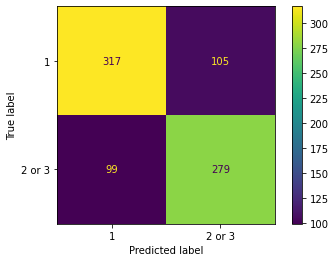

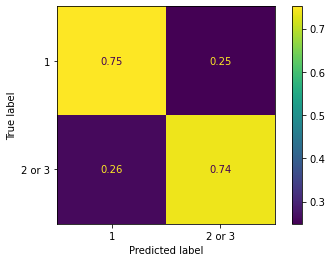

In [26]:
model_result(svc, svc_name)

### Bernoulli Naive Bayes

In [27]:
nb, nb_name = model_lst[1], model_name_lst[1]

The model name is Bernoulli Naive Bayes.
Test accuracy is 0.8012
F1 score is 0.8082
Precision score is 0.8231
Recall score is 0.7938


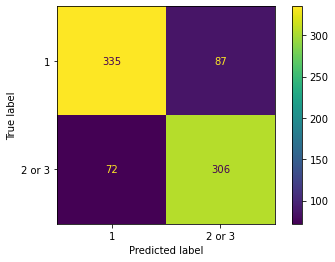

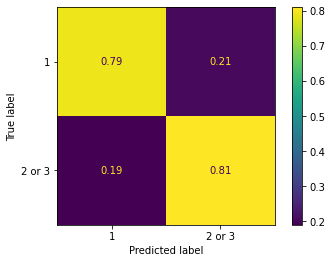

In [28]:
model_result(nb, nb_name)

### Random Forest Classifier

In [29]:
rfc, rfc_name = model_lst[2], model_name_lst[2]

The model name is Random Forest Classifier.
Test accuracy is 0.7938
F1 score is 0.8061
Precision score is 0.7995
Recall score is 0.8128


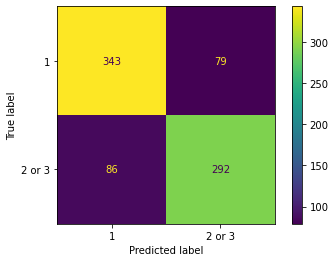

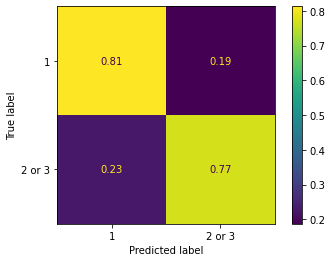

In [30]:
model_result(rfc, rfc_name)

### Logistic Regression

In [31]:
log, log_name = model_lst[3], model_name_lst[3]

The model name is Logistic Regression.
Test accuracy is 0.7762
F1 score is 0.7872
Precision score is 0.79
Recall score is 0.7844


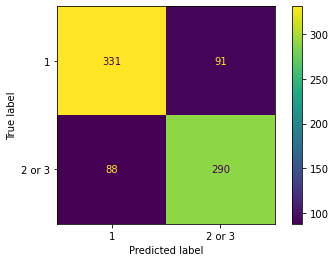

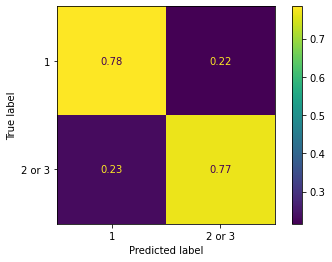

In [32]:
model_result(log, log_name)

### Lasso

In [33]:
lasso, lasso_name = model_lst[4], model_name_lst[4]

The model name is Lasso.
Test accuracy is 0.78
F1 score is 0.7838
Precision score is 0.8138
Recall score is 0.7559


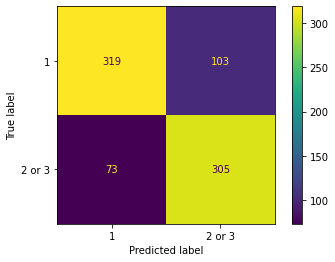

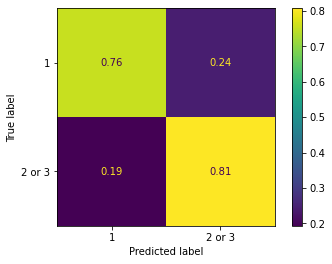

In [34]:
model_result(lasso, lasso_name)

### Ridge

In [35]:
ridge, ridge_name = model_lst[5], model_name_lst[5]

The model name is Ridge.
Test accuracy is 0.7375
F1 score is 0.747
Precision score is 0.7598
Recall score is 0.7346


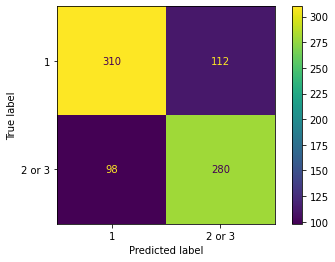

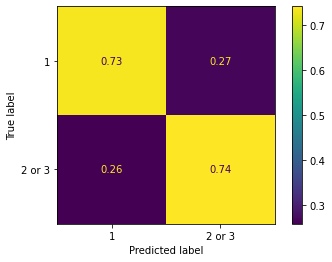

In [36]:
model_result(ridge, ridge_name)

### Grid Search

In [37]:
from sklearn.model_selection import GridSearchCV

In [38]:
B_NB_pipeline = Pipeline([
                ('preprocessor', preprocessor),
                ('clf', BernoulliNB(class_prior=None)),
            ])

param_grid = {
    "clf__alpha": [0, 1],
    "clf__binarize": [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
    "clf__fit_prior": [True, False]
}

search = GridSearchCV(B_NB_pipeline, param_grid, n_jobs=2)
# train the model using X_dtm & y
search.fit(X_train, Y_train)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Best parameter (CV score=0.800):
{'clf__alpha': 1, 'clf__binarize': 0.7, 'clf__fit_prior': True}


Test accuracy is 0.8
F1 score is 0.8048780487804877
Precision score is 0.8291457286432161
Recall score is 0.7819905213270142


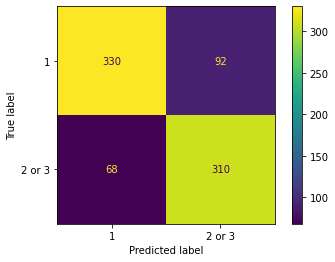

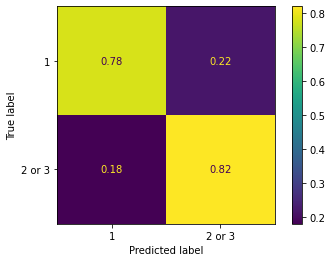

In [39]:
B_NB_pipeline = Pipeline([
                ('preprocessor', preprocessor),
                ('clf', OneVsRestClassifier(BernoulliNB(alpha=1, binarize=0.8, fit_prior=True, class_prior=None))),
            ])

# train the model using X_dtm & y
B_NB_pipeline.fit(X_train, Y_train)
# compute the testing accuracy
prediction = B_NB_pipeline.predict(pd.DataFrame(X_test))
print('Test accuracy is {}'.format(accuracy_score(Y_test, prediction)))
# compute the f1 score
f1 = f1_score(np.array(Y_test), prediction, pos_label='1')
print('F1 score is {}'.format(f1))
# compute the precision score
precision = precision_score(np.array(Y_test), prediction, pos_label='1', average='binary')
print('Precision score is {}'.format(precision))
# compute the precision score
recall = recall_score(np.array(Y_test), prediction, pos_label='1', average='binary')
print('Recall score is {}'.format(recall))
plot_confusion_matrix(B_NB_pipeline, X_test, Y_test)
plt.show()
plot_confusion_matrix(B_NB_pipeline, X_test, Y_test, normalize='true')
plt.show()